# DANRA figures

This notebooks documents and presents the figures created for and included in the submitted manuscript.

## Import packages and datasets

In [1]:
from pathlib import Path
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import cdsapi
import tempfile
import matplotlib.patheffects as patheffects
import cartopy.feature as cfeature

In [2]:
# Load the zarr DANRA dataset

ds_danra_sl = xr.open_zarr(
    "s3://dmi-danra-05/single_levels.zarr",
    consolidated=True,
    storage_options={
        "anon": True,
    },
)

ds_danra_sl.attrs["suite_name"] = "danra"

In [3]:
# Print dataset information
ds_danra_sl

<xarray.Dataset> Size: 10TB
Dimensions:           (time: 96768, y: 589, x: 789)
Coordinates:
  * time              (time) datetime64[ns] 774kB 1990-09-01 ... 2023-10-13T2...
  * y                 (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.605e+05
  * x                 (x) float64 6kB -1.999e+06 -1.997e+06 ... -2.925e+04
    lat               (y, x) float64 4MB dask.array<chunksize=(295, 263), meta=np.ndarray>
    lon               (y, x) float64 4MB dask.array<chunksize=(295, 263), meta=np.ndarray>
Data variables: (12/31)
    cape_column       (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    cb_column         (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    ct_column         (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    danra_projection  float64 8B ...
    grpl_column       (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    hcc0m             (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    ...                ...
    t2m               (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    tcc0m             (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    u10m              (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    v10m              (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    vis0m             (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
    xhail0m           (time, y, x) float64 360GB dask.array<chunksize=(256, 295, 263), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    contact:      Leif Denby <lcd@dmi.dk>, Danish Meteorological Institute
    description:  All prognostic variables for 1990-09-01T00:00Z to 2024-01-0...
    license:      CC-BY-4.0: https://creativecommons.org/licenses/by/4.0/
    suite_name:   danra

In [4]:
# Download ERA5 data using the CDS API
# store in a temporary file

import os


dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": ["geopotential", "land_sea_mask"],
    "year": ["1991"],
    "month": ["01"],
    "day": ["01"],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [60, 0, -50, 20],
}

temp_file = tempfile.NamedTemporaryFile(suffix=".grib", delete=False)
target = Path(temp_file.name)
temp_file.close()

if target.stat().st_size > 0:
    print(f"File {target} already exists, skipping download.")
else:
    print(f"Downloading ERA5 data to {target}...")
    client = cdsapi.Client()
    client.retrieve(dataset, request, target.as_posix())

2025-10-12 14:01:17,194 INFO Request ID is 3d1c6059-6791-41ae-8e11-2a50d0705230
2025-10-12 14:01:17,272 INFO status has been updated to accepted
2025-10-12 14:01:31,237 INFO status has been updated to running
2025-10-12 14:01:38,908 INFO status has been updated to successful


In [5]:
# Open the downloaded ERA5 GRIB file and extract fields and lat/lon
era5_grib = xr.open_dataset(
    target,
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface"}, "indexpath": ""},
)

# Extract fields and coordinates
era5_geopotential = era5_grib["z"]  # geopotential
era5_lsm = era5_grib["lsm"]  # land-sea mask
era5_lat = era5_grib["latitude"]
era5_lon = era5_grib["longitude"]

era5_geopotential, era5_lsm, era5_lat, era5_lon

(<xarray.DataArray 'z' (latitude: 441, longitude: 81)> Size: 143kB
 [35721 values with dtype=float32]
 Coordinates:
   * latitude    (latitude) float64 4kB 60.0 59.75 59.5 ... -49.5 -49.75 -50.0
   * longitude   (longitude) float64 648B 0.0 0.25 0.5 0.75 ... 19.5 19.75 20.0
     number      int64 8B ...
     time        datetime64[ns] 8B ...
     step        timedelta64[ns] 8B ...
     surface     float64 8B ...
     valid_time  datetime64[ns] 8B ...
 Attributes: (12/31)
     GRIB_paramId:                             129
     GRIB_dataType:                            an
     GRIB_numberOfPoints:                      35721
     GRIB_typeOfLevel:                         surface
     GRIB_stepUnits:                           1
     GRIB_stepType:                            instant
     ...                                       ...
     GRIB_shortName:                           z
     GRIB_totalNumber:                         0
     GRIB_units:                               m**2 s**-2
    

## Figure 1: DANRA domain, danra and era5 orography

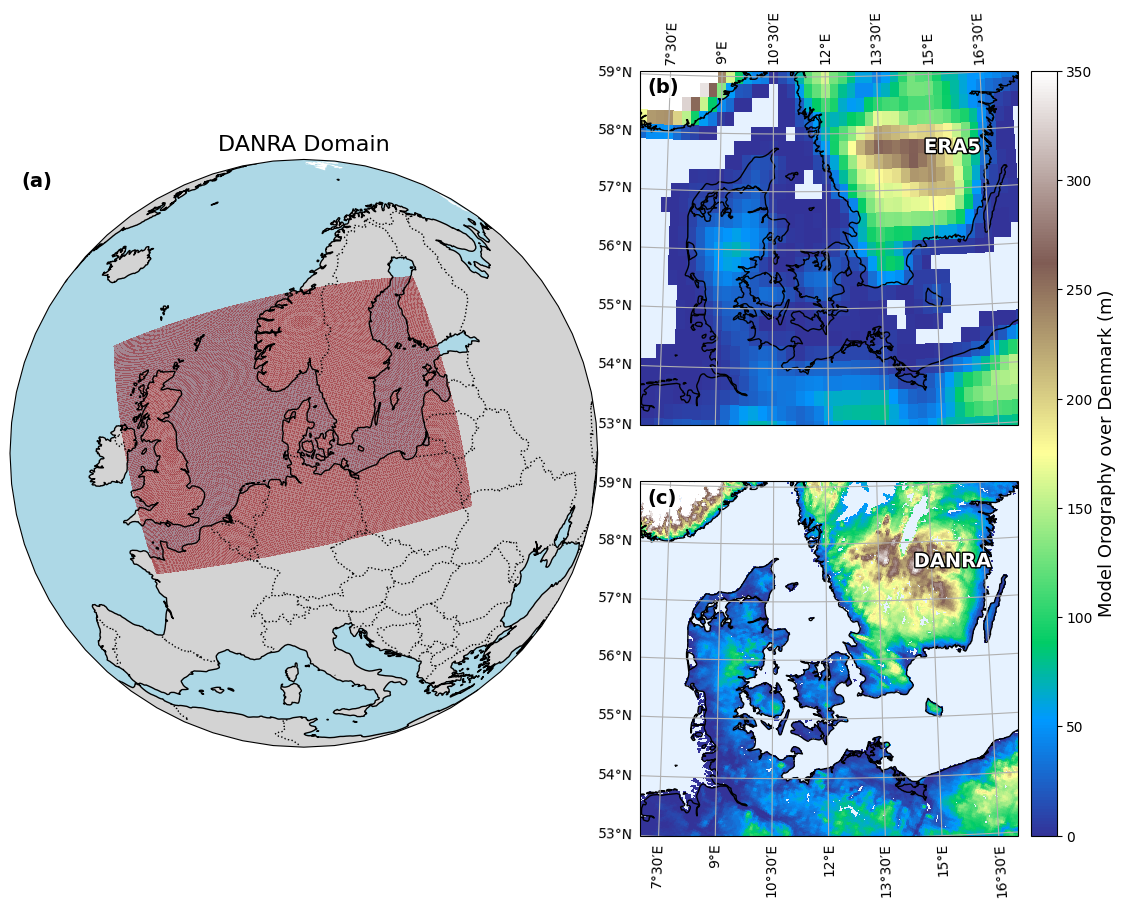

In [6]:
# Plot orography for DANRA and ERA5 datasets with bounding boxes in new layout

orog = ds_danra_sl.orography / 9.82  # Convert to meters
orog = orog.where(ds_danra_sl.lsm != 0)  # Set sea points (lsm == 0) to NaN
lat = ds_danra_sl.lat
lon = ds_danra_sl.lon
era_orog = era5_geopotential / 9.82  # Convert to meters
era5_orog = era_orog.where(era5_lsm != 0)

fig = plt.figure(figsize=(13, 10.4))
gs = fig.add_gridspec(2, 5, wspace=0.25, hspace=0.05)

# Globe subplot (left, spans both rows)
ax_globe = fig.add_subplot(
    gs[:, 0:3],
    projection=ccrs.NearsidePerspective(
        central_latitude=55, central_longitude=10, satellite_height=8.5e5
    ),
)
ax_globe.set_global()
ax_globe.coastlines()
ax_globe.set_title("DANRA Domain", fontsize=16)

ax_globe.text(
    0.02,
    0.98,
    "(a)",
    transform=ax_globe.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
)

# Draw DANRA domain
ax_globe.add_feature(cfeature.BORDERS, linestyle=":")
ax_globe.add_feature(cfeature.LAND, facecolor="lightgray")
ax_globe.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax_globe.pcolormesh(
    lon,
    lat,
    np.ones_like(ds_danra_sl.lsm),
    transform=ccrs.PlateCarree(),
    cmap="Reds",
    vmin=0,
    vmax=1.1,
    alpha=0.4,
)
plot_bbox = [7, 53, 17, 59]  # [min_lon, min_lat, max_lon, max_lat]

# ERA5 orography subplot (top right)
ax_era5 = fig.add_subplot(
    gs[0, 3:],
    projection=ccrs.AlbersEqualArea(central_longitude=11.0, central_latitude=55.0),
)
ax_era5.set_facecolor("#e6f2ff")
mesh1 = ax_era5.pcolormesh(
    era5_lon,
    era5_lat,
    era5_orog.squeeze(),
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=0,
    vmax=350,
    rasterized=True,
)
ax_era5.coastlines()
ax_era5.set_extent([7, 17, 53, 59], crs=ccrs.PlateCarree())
gl1 = ax_era5.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl1.top_labels = True
gl1.bottom_labels = False
gl1.left_labels = True
gl1.right_labels = False

# DANRA orography subplot (bottom right)
ax_danra = fig.add_subplot(
    gs[1, 3:],
    projection=ccrs.AlbersEqualArea(central_longitude=11.0, central_latitude=55.0),
)
ax_danra.set_facecolor("#e6f2ff")
mesh0 = ax_danra.pcolormesh(
    lon,
    lat,
    orog.values,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=0,
    vmax=350,
    rasterized=True,
)
ax_danra.coastlines()
ax_danra.set_extent([7, 17, 53, 59], crs=ccrs.PlateCarree())
gl0 = ax_danra.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl0.top_labels = False
gl0.bottom_labels = True
gl0.left_labels = True
gl0.right_labels = False

# Create an axis for the colorbar that spans both right subplots
cbar_ax = fig.add_axes(
    [
        0.91,
        ax_danra.get_position().y0,
        0.02,
        ax_era5.get_position().y1 - ax_danra.get_position().y0,
    ]
)
cbar = fig.colorbar(mesh1, cax=cbar_ax, orientation="vertical")
cbar.set_label("Model Orography over Denmark (m)", fontsize=13)

ax_era5.text(
    0.02,
    0.98,
    "(b)",
    transform=ax_era5.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
)
ax_danra.text(
    0.02,
    0.98,
    "(c)",
    transform=ax_danra.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1),
)


fig.text(
    0.85,
    0.78,
    "ERA5",
    color="white",
    fontsize=14,
    ha="center",
    va="bottom",
    fontweight="bold",
    path_effects=[patheffects.withStroke(linewidth=2, foreground="black")],
)

fig.text(
    0.85,
    0.4,
    "DANRA",
    color="white",
    fontsize=14,
    ha="center",
    va="top",
    fontweight="bold",
    path_effects=[patheffects.withStroke(linewidth=2, foreground="black")],
)

plt.show()